# **Vehicle Detection and Classification ARTIFICIAL NEURAL NETWORKS** 

In this project, I combine computer vision techniques and machine learning to identify vehicles in a video stream. 

In [1]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Set Test Image for Feature Extraction

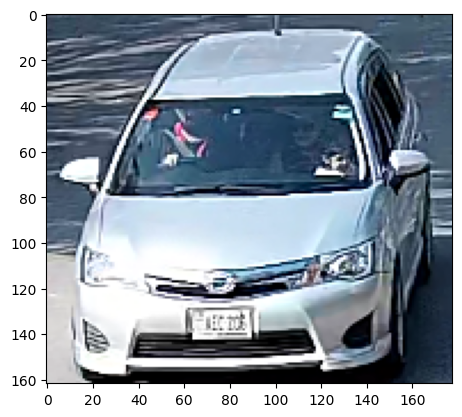

In [2]:
test_img_loc = '../dataset/car-cropped.png'
feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
plt.imshow(feature_image)
plt.show()

In [3]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
canny_feat=True
y_start_stop = [400, 650] # Min and max in y to search in slide_window()

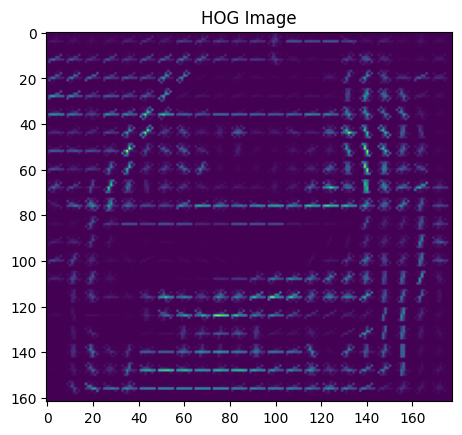

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
hog_features, hog_image = get_hog_features(feature_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.imshow(hog_image)
plt.title('HOG Image')
plt.show()

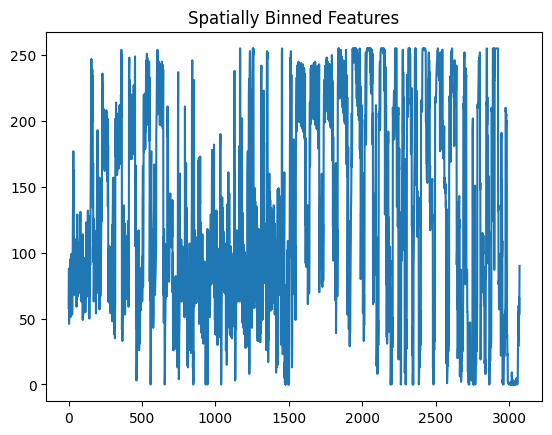

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Plot features
feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
feature_vec = bin_spatial(feature_image, size=spatial_size)
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.show()

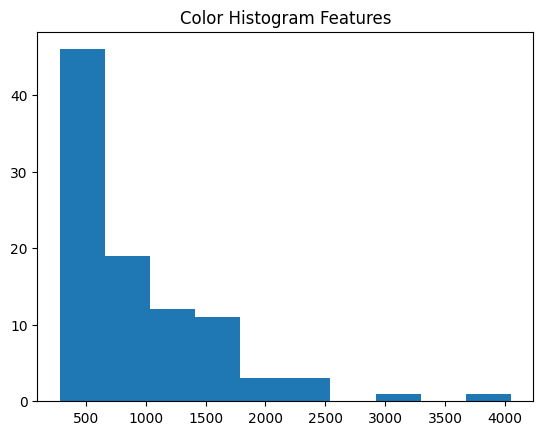

In [6]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
hist_features = color_hist(feature_image, nbins=hist_bins)
plt.hist(hist_features)
plt.title('Color Histogram Features')
plt.show()

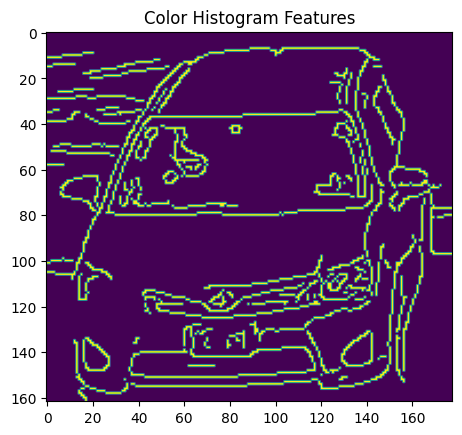

In [7]:
def cannyEdge(img):
    med_value = np.median(img)
    lower = int(max(0, 0.7 * med_value))
    upper = int(min(255, 1.13 * med_value))
    blured_img = cv2.GaussianBlur(img, (7, 7), 0)
    edge = cv2.Canny(image=blured_img, threshold1=lower, threshold2=upper)
    return edge

feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
canny_feature = cannyEdge(feature_image)
plt.imshow(canny_feature)
plt.title('Color Histogram Features')
plt.show()

In [8]:
import cv2
import numpy as np

def resize_if_needed(image, target_size=(64, 64)):
    if image.shape[0] < target_size[0] or image.shape[1] < target_size[1]:
        image = cv2.resize(image, target_size)
    return image

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,canny_feat=True):    
    img = resize_if_needed(img)
    
    img_features = []
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    
  
    if spatial_feat:
        print("Extracting: Spatial Feature")
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    
    if hist_feat :
        print("Extracting: Hist Feature")
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    
    if hog_feat:
        print("Extracting: Hog Feature")
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:, :, channel], 
                                                     orient, pix_per_cell, cell_per_block, 
                                                     vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient, 
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    if canny_feat:
        print("Extracting: Canny_Feature")
   
        gray_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
        canny_features = cannyEdge(gray_image).flatten()
        img_features.append(canny_features)
    

    return np.concatenate(img_features)

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True,canny_feat=True):
    features = []
    
    for file in imgs:
        img = cv2.imread(file)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img=cv2.resize(img,(128,128))
            file_features = single_img_features(img, color_space, spatial_size,
                                                hist_bins, orient, pix_per_cell, 
                                                cell_per_block, hog_channel, spatial_feat, 
                                                hist_feat, hog_feat,canny_feat)
            features.append(file_features)
        else:
            print(f"Warning: Could not read image {file}")
    
    return features


In [9]:
def prepare_images_for_processing(cars_folder, motorcycles_folder, non_vehicles_folder, image_type):
    cars = []
    for folder in cars_folder:
        cars += glob.glob(folder + '/*.' + image_type)

    motorcycles = []
    for folder in motorcycles_folder:
        motorcycles += glob.glob(folder + '/*.' + image_type)

    non_vehicles = []
    for folder in non_vehicles_folder:
        non_vehicles += glob.glob(folder + '/*.' + image_type)

    print("Cars len: ", len(cars))
    print("Motorcycles len: ", len(motorcycles))
    print("Non-vehicles len: ", len(non_vehicles))


    
    car_features = extract_features(cars, color_space=color_space, 
        spatial_size=spatial_size, hist_bins=hist_bins, 
        orient=orient, pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block, 
        hog_channel=hog_channel, spatial_feat=spatial_feat, 
        hist_feat=hist_feat, hog_feat=hog_feat,canny_feat=canny_feat)

    motorcycle_features = extract_features(motorcycles, color_space=color_space, 
        spatial_size=spatial_size, hist_bins=hist_bins, 
        orient=orient, pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block, 
        hog_channel=hog_channel, spatial_feat=spatial_feat, 
        hist_feat=hist_feat, hog_feat=hog_feat,canny_feat=canny_feat)

    non_vehicle_features = extract_features(non_vehicles, color_space=color_space, 
        spatial_size=spatial_size, hist_bins=hist_bins, 
        orient=orient, pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block, 
        hog_channel=hog_channel, spatial_feat=spatial_feat, 
        hist_feat=hist_feat, hog_feat=hog_feat,canny_feat=canny_feat)

    X = np.vstack((car_features, motorcycle_features, non_vehicle_features)).astype(np.float64)

    X_scaler = StandardScaler().fit(X)

    scaled_X = X_scaler.transform(X)

    y = np.hstack((np.ones(len(car_features)), 
                   np.full(len(motorcycle_features), 2), 
                   np.zeros(len(non_vehicle_features))))

    return scaled_X, y, X_scaler


In [ ]:



car_folders = ['../dataset/images/cars']
motorcycles_folder = ['../dataset/images/motorcycles']
non_vehicles_folder = ['../dataset/images/non_vehicles']

scaled_X, y, X_scaler = prepare_images_for_processing(car_folders, motorcycles_folder, non_vehicles_folder, "jpg")


rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


In [ ]:

ann_model = tf.keras.Sequential()
ann_model.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)))
ann_model.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann_model.add(tf.keras.layers.Dense(units=32, activation='relu'))
ann_model.add(tf.keras.layers.Dense(units=3, activation='softmax'))
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = ann_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
loss, accuracy = ann_model.evaluate(X_test, y_test)
print(f"ANN model accuracy: {accuracy * 100:.2f}%")


In [ ]:
ann_model_filename = 'ann_model.h5'
ann_model.save(ann_model_filename)

print(f"Model saved to {ann_model_filename}")


In [ ]:
import cv2
import numpy as np

def sliding_window(image, step_size, window_size):
    h, w = window_size
    image_h, image_w = image.shape[:2]

    for y in range(0, image_h, step_size):
        for x in range(0, image_w, step_size):
            window = image[y:y + h, x:x + w]
            if window.shape[:2] != window_size:
                continue
            yield (x, y, window)

import cv2
import numpy as np

def intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

def non_max_suppression(rectangles, iou_threshold=0.3):
    if len(rectangles) == 0:
        return []

    final_rectangles = []

    rectangles = sorted(rectangles, key=lambda x: x[2] * x[3], reverse=True)

    while len(rectangles) > 0:
        current = rectangles.pop(0)
        final_rectangles.append(current)
        rectangles = [rect for rect in rectangles if intersection_over_union(current, rect) < iou_threshold]
    return final_rectangles

def detect_vehicles_in_frame(frame, svc, scaler, window_size=(400, 400), step_size=100, iou_threshold=0.3):
    detected_objects = []
    rectangles = []

    for (x, y, window) in sliding_window(frame, step_size, window_size):
        if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
            continue
        
        resized_window = cv2.resize(window, (128, 128))
        features = single_img_features(resized_window, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = svc.predict(test_features)
        
        if prediction == 1:
            print("cars")
            rectangles.append((x, y, window_size[0], window_size[1]))

    final_rectangles = non_max_suppression(rectangles, iou_threshold=iou_threshold)

    for (x, y, w, h) in final_rectangles:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, "cars", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        detected_objects.append((x, y, "cars"))
    return frame, detected_objects

In [ ]:
def process_video(input_path, output_path, model, scaler, window_size=(400,400), step_size=100):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: Couldn't open video file {input_path}")
        return
    
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Define the codec and create the video writer object
    writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))

    frame_idx = 0
    while cap.isOpened():
        print(f"Processing frame: {frame_idx}")
        ret, frame = cap.read()
        if not ret:
            print(f"End of video at frame {frame_idx}")
            break

        frame, detected_objects = detect_vehicles_in_frame(frame, model,scaler, window_size, step_size)
        
        writer.write(frame)
        frame_idx += 1

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    writer.release()
    cv2.destroyAllWindows()
    print(f"Video processing complete. Output saved to {output_path}")



process_video('../dataset/sample videos/sample.mp4', 'final_output.mp4', gnb, X_scaler)
